<a href="https://colab.research.google.com/github/vit050587/PyTorch/blob/master/KVA_PYTORCH_HW_03_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Попрактикуемся с тем, что изучили

Будем практиковаться на датасете:
sklearn.datasets.fetch_california_housing

Ваша задача:
1. Создать Dataset для загрузки данных (используем только числовые данные)
2. Обернуть его в Dataloader
3. Написать архитектуру сети, которая предсказывает число показов на основании числовых данных (вы всегда можете нагенерить дополнительных факторов). Сеть должна включать BatchNorm слои и Dropout (или НЕ включать, но нужно обосновать)
4. Учить будем на функцию потерь с кагла (log RMSE) - нужно её реализовать
5. Сравните сходимость Adam, RMSProp и SGD, сделайте вывод по качеству работы модели

train-test разделение нужно сделать с помощью sklearn random_state=13, test_size = 0.25

Вопросы? в личку @Kinetikm

In [2]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 10.6 MB/s eta 0:00:00


In [3]:
import torch
import torch.nn as nn
import sklearn
import numpy as np
import pandas as pd
import torchmetrics
import torch.nn.functional as F

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

In [4]:
train_dataset = sklearn.datasets.fetch_california_housing()
train_dataset

{'data': array([[   8.3252    ,   41.        ,    6.98412698, ...,    2.55555556,
           37.88      , -122.23      ],
        [   8.3014    ,   21.        ,    6.23813708, ...,    2.10984183,
           37.86      , -122.22      ],
        [   7.2574    ,   52.        ,    8.28813559, ...,    2.80225989,
           37.85      , -122.24      ],
        ...,
        [   1.7       ,   17.        ,    5.20554273, ...,    2.3256351 ,
           39.43      , -121.22      ],
        [   1.8672    ,   18.        ,    5.32951289, ...,    2.12320917,
           39.43      , -121.32      ],
        [   2.3886    ,   16.        ,    5.25471698, ...,    2.61698113,
           39.37      , -121.24      ]]),
 'target': array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894]),
 'frame': None,
 'target_names': ['MedHouseVal'],
 'feature_names': ['MedInc',
  'HouseAge',
  'AveRooms',
  'AveBedrms',
  'Population',
  'AveOccup',
  'Latitude',
  'Longitude'],
 'DESCR': '.. _california_housing_dataset:\n

In [5]:
data = train_dataset.data
target = train_dataset.target

In [6]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.25, random_state=13)

In [7]:
# сделаем стандарт-скейлер так как это задача регрессии и мин-макс скейлер будет хуже работать

scaler = MinMaxScaler()
# scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [8]:
class MyOwnCH(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    
    
train_dataset = MyOwnCH(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
test_dataset = MyOwnCH(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())

In [9]:
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True, drop_last=True, num_workers=0)
test_loader = DataLoader(dataset=test_dataset, batch_size=8, shuffle=False, drop_last=True, num_workers=0)

In [10]:
class Perceptron(nn.Module):
    def __init__(self, input_dim, output_dim, activation="relu"):
        super(Perceptron, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)
        self.activation = activation
        
    def forward(self, x):
        x = self.fc(x)
        if self.activation == "relu":
            return F.relu(x)
        if self.activation == "sigmoid":
            return F.sigmoid(x)
        raise RuntimeError
        
class FeedForward(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(FeedForward, self).__init__()
        self.bn1 = nn.BatchNorm1d(input_dim)
        self.fc1 = Perceptron(input_dim, 2 * hidden_dim)
        self.dp1 = nn.Dropout(0.25)
        self.bn2 = nn.BatchNorm1d(2 * hidden_dim)
        self.fc2 = Perceptron(2 * hidden_dim, hidden_dim)
        self.dp2 = nn.Dropout(0.25)
        self.bn3 = nn.BatchNorm1d(hidden_dim)
        self.fc3 = Perceptron(hidden_dim, 1)
        
    def forward(self, x):
        x = self.bn1(x)
        x = self.fc1(x)
        x = self.dp1(x)
        x = self.bn2(x)
        x = self.fc2(x)
        x = self.dp2(x)
        x = self.bn3(x)
        x = self.fc3(x)
        return x

In [11]:
def model_comparing(model, optimizer):    
    
    train_r2 = torchmetrics.R2Score()
    test_r2 = torchmetrics.R2Score()

    r2_train_list = []
    r2_test_list = []
    
    for epoch in range(30):
        
        model.train()
        
        for i, data in enumerate(train_loader):
            inputs, target = data[0], data[1]
            optimizer.zero_grad()
            outputs = model(inputs)
            batch_r2 = train_r2(outputs.squeeze(), target)
            # Рассчитываем лосс-функцию (функцию потерь)
            loss = criterion(outputs.squeeze(), target)
            loss.backward()
            optimizer.step()
        
        model.eval()
        
        for i, data in enumerate(test_loader):
            inputs, target = data[0], data[1]
            outputs = model(inputs)
            test_r2(outputs.squeeze(), target)

        # total r2 over all training batches
        total_train_r2 = train_r2.compute()
        # total r2 over all training batches
        total_test_r2 = test_r2.compute()
        
        r2_train_list.append(total_train_r2)
        r2_test_list.append(total_test_r2)
        print(f'Epoch {epoch+1}: r2_train = {total_train_r2}, r2_test = {total_test_r2}')

        #reset for next epoch
        train_r2.reset()
        test_r2.reset()
    
    return r2_train_list, r2_test_list

In [12]:
def metrics_view(r2_train_list, r2_test_list, optim):
    
    epoch = np.arange(1,31,1)
    y_train = r2_train_list
    y_test = r2_test_list
    plt.plot(epoch, y_train, label='R2_train')
    plt.plot(epoch, y_test, label='R2_test')
    plt.title(f"{optim}")   
    plt.ylabel('R2_score')   
    plt.xlabel('epochs')   
    plt.legend()
    plt.show()

#SGD


In [13]:
model = FeedForward(8, 400)
print(model)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0005, momentum=0.0)
r2_train_SGD, r2_test_SGD = model_comparing(model, optimizer)

# optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

FeedForward(
  (bn1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Perceptron(
    (fc): Linear(in_features=8, out_features=800, bias=True)
  )
  (dp1): Dropout(p=0.25, inplace=False)
  (bn2): BatchNorm1d(800, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Perceptron(
    (fc): Linear(in_features=800, out_features=400, bias=True)
  )
  (dp2): Dropout(p=0.25, inplace=False)
  (bn3): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Perceptron(
    (fc): Linear(in_features=400, out_features=1, bias=True)
  )
)
Epoch 1: r2_train = -0.9155299663543701, r2_test = -0.26685285568237305
Epoch 2: r2_train = -0.3005037307739258, r2_test = -0.053232669830322266
Epoch 3: r2_train = -0.1383044719696045, r2_test = 0.08463561534881592
Epoch 4: r2_train = -0.046471595764160156, r2_test = 0.11255818605422974
Epoch 5: r2_train = 0.0114327073097229, r2_test = 0.24320143461227417
Epoch 6: r2_train 

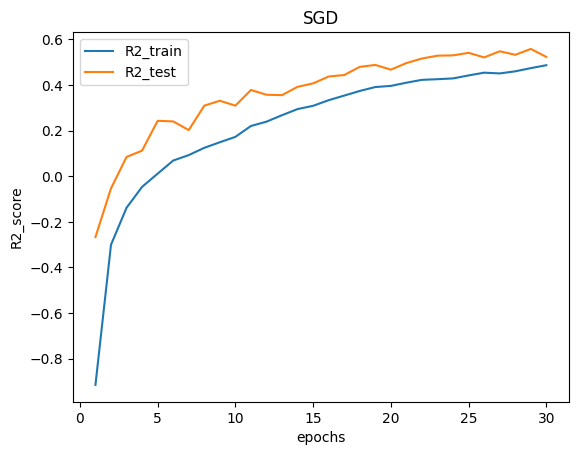

In [14]:
metrics_view(r2_train_SGD, r2_test_SGD, 'SGD')

#RMSprop

In [15]:
model = FeedForward(8, 400)
# print(model)
criterion = nn.MSELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.0005)
r2_train_RMSprop, r2_test_RMSprop = model_comparing(model, optimizer)

Epoch 1: r2_train = 0.2191796898841858, r2_test = 0.5169250965118408
Epoch 2: r2_train = 0.493491530418396, r2_test = 0.5718495845794678
Epoch 3: r2_train = 0.5682117938995361, r2_test = 0.6129109859466553
Epoch 4: r2_train = 0.6090445518493652, r2_test = 0.6649378538131714
Epoch 5: r2_train = 0.6273586750030518, r2_test = 0.6966460943222046
Epoch 6: r2_train = 0.6413842439651489, r2_test = 0.6447936296463013
Epoch 7: r2_train = 0.6508932113647461, r2_test = 0.7193080186843872
Epoch 8: r2_train = 0.6576340198516846, r2_test = 0.7083730697631836
Epoch 9: r2_train = 0.6670218706130981, r2_test = 0.718229353427887
Epoch 10: r2_train = 0.6779001951217651, r2_test = 0.7415065765380859
Epoch 11: r2_train = 0.6718568801879883, r2_test = 0.6883370876312256
Epoch 12: r2_train = 0.675940752029419, r2_test = 0.6860432624816895
Epoch 13: r2_train = 0.687673807144165, r2_test = 0.7410311698913574
Epoch 14: r2_train = 0.688705325126648, r2_test = 0.6874452829360962
Epoch 15: r2_train = 0.69724422693

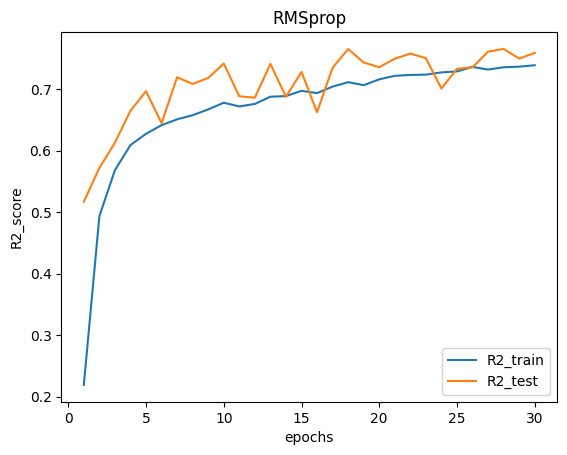

In [16]:
metrics_view(r2_train_RMSprop, r2_test_RMSprop, 'RMSprop')

#ADAM

In [17]:
model = FeedForward(8, 400)
# print(model)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
r2_train_Adam, r2_test_Adam = model_comparing(model, optimizer)

Epoch 1: r2_train = -0.024416089057922363, r2_test = 0.3840200901031494
Epoch 2: r2_train = 0.41534364223480225, r2_test = 0.553415060043335
Epoch 3: r2_train = 0.5327067375183105, r2_test = 0.6266765594482422
Epoch 4: r2_train = 0.5828343629837036, r2_test = 0.6727108359336853
Epoch 5: r2_train = 0.6154495477676392, r2_test = 0.6808849573135376
Epoch 6: r2_train = 0.6379179954528809, r2_test = 0.6615248322486877
Epoch 7: r2_train = 0.6584374904632568, r2_test = 0.6772515177726746
Epoch 8: r2_train = 0.6500844359397888, r2_test = 0.6851692199707031
Epoch 9: r2_train = 0.666400134563446, r2_test = 0.7186592817306519
Epoch 10: r2_train = 0.6684495210647583, r2_test = 0.698256254196167
Epoch 11: r2_train = 0.6732255816459656, r2_test = 0.7032532691955566
Epoch 12: r2_train = 0.6796650290489197, r2_test = 0.7277594804763794
Epoch 13: r2_train = 0.6933430433273315, r2_test = 0.7245461344718933
Epoch 14: r2_train = 0.6951537132263184, r2_test = 0.6622493863105774
Epoch 15: r2_train = 0.69546

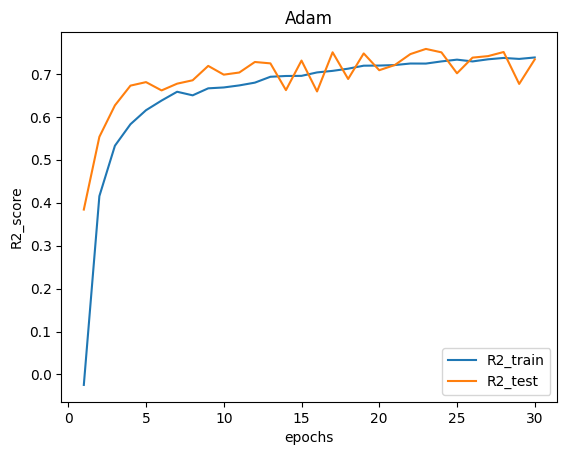

In [18]:
metrics_view(r2_train_Adam, r2_test_Adam, 'Adam')

#Сравнение метрик

In [19]:
metrics_result = pd.DataFrame([{'r2_train': r2_train_SGD[-1].item(), 'r2_test': r2_test_SGD[-1].item()},
                               {'r2_train': r2_train_RMSprop[-1].item(), 'r2_test': r2_test_RMSprop[-1].item()},
                               {'r2_train': r2_train_Adam[-1].item(), 'r2_test': r2_test_Adam[-1].item()},
                              ],
                              index = ['SGD', 'RMSprop', 'Adam'], 
                              columns = ['r2_train', 'r2_test'])

metrics_result.sort_values(by='r2_test', ascending=False)

,r2_train,r2_test
RMSprop,0.738869,0.758888
Adam,0.738288,0.733747
SGD,0.487248,0.523402


#Вывод:

Алгоримт SGD долго сходится - но достаточно стабильно. Ему требуется больше эпох, чтобы прийти к значениям метрик, которые достигаются другими алгоритмами значительно быстрее.

Алгоритмы Adam и RMSprop сходятся примерно одинаково. И быстрее чем SGD.